# Deep Dive: Neuron Morphology Analysis

This comprehensive tutorial explores the morphological analysis capabilities of CRANTpy. We'll cover:

1. **Mesh representations** - Fetching and analyzing neuron meshes
2. **Skeleton representations** - Multiple skeletonization methods
3. **L2 graph-based skeletons** - High-quality morphology from L2 chunks
4. **Dotprops** - Point cloud representations for fast analysis
5. **Morphometric analysis** - Cable length, surface area, volume, branching
6. **Soma detection** - Automated soma identification
7. **Visualization** - 2D and 3D visualization techniques
8. **Population analysis** - Comparing morphology across neuron groups
9. **Navis integration** - Leveraging navis for advanced analysis

Let's start by setting up our environment.

In [1]:
# Import CRANTpy and other necessary libraries
import crantpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import navis
import cloudvolume as cv
import networkx as nx

# Set up logging
cp.set_logging_level("WARNING")

print("CRANTpy loaded successfully!")
print(f"Default dataset: {cp.CRANT_DEFAULT_DATASET}")
print(f"Navis version: {navis.__version__}")

CRANTpy loaded successfully!
Default dataset: latest
Navis version: 1.10.0


## 1. Authentication Setup

First, ensure you are authenticated with the CAVE service.

In [2]:
# Generate and save authentication token (uncomment if first time)
# cp.generate_cave_token(save=True)

# Test connection
try:
    client = cp.get_cave_client()
    print(f"Successfully connected to datastack: {client.datastack_name}")
    print(f"Server: {client.server_address}")
except Exception as e:
    print(f"Connection failed: {e}")
    print("Please run: cp.generate_cave_token(save=True)")

Successfully connected to datastack: kronauer_ant
Server: https://proofreading.zetta.ai


## 2. Getting Sample Neurons

Let's query some neurons for our morphology analysis.

In [3]:
# Get a sample of olfactory projection neurons
opn_criteria = cp.NeuronCriteria(cell_class='olfactory_projection_neuron')
opn_ids = opn_criteria.get_roots()
print(f"Found {len(opn_ids)} olfactory projection neurons")

# Select a few for detailed analysis
sample_ids = opn_ids[:3]
print(f"\nSample neurons for detailed analysis:")
for i, neuron_id in enumerate(sample_ids, 1):
    print(f"  {i}. {neuron_id}")

Found 107 olfactory projection neurons

Sample neurons for detailed analysis:
  1. 576460752700282748
  2. 576460752681552812
  3. 576460752722405178


## 3. Mesh Representations

Meshes provide the most detailed representation of neuron morphology, capturing the full 3D surface.

### Fetching Mesh Neurons

In [4]:
# Fetch a single mesh neuron
single_mesh = cp.get_mesh_neuron(sample_ids[0])
print(f"Mesh neuron properties:")
print(f"  ID: {single_mesh.id}")
print(f"  Vertices: {len(single_mesh.vertices):,}")
print(f"  Faces: {len(single_mesh.faces):,}")
print(f"  Volume: {single_mesh.volume:.2f} cubic nanometers")

Mesh neuron properties:
  ID: 576460752700282748
  Vertices: 238,432
  Faces: 478,609
  Volume: 135639679325.33 cubic nanometers


In [5]:
# Fetch multiple mesh neurons
mesh_neurons = cp.get_mesh_neuron(sample_ids, threads=3, progress=True)
print(f"\nFetched {len(mesh_neurons)} mesh neurons")

# Summary of meshes
for n in mesh_neurons:
    print(f"  {n.id}: {len(n.vertices):,} vertices, {n.volume:.2f} μm³")

Fetching meshes:   0%|          | 0/3 [00:00<?, ?it/s]


Fetched 3 mesh neurons
  576460752700282748: 238,432 vertices, 135639679325.33 μm³
  576460752681552812: 309,633 vertices, 192266769082.67 μm³
  576460752722405178: 248,290 vertices, 154247730149.33 μm³


### Soma Detection

We can use the function `detect_soma` to retrieve the estimated pixel coordinates of a neuron's soma. We can then use a helper function to visually inspect this area in the raw EM data to verify it contains a nucleus. 

In [6]:
# Detect soma for a single neuron
soma_coords = cp.detect_soma(sample_ids[0])
print(f"Soma detected at coordinates: {soma_coords}")

# Detect soma for multiple neurons
soma_coords_batch = cp.detect_soma(sample_ids, progress=True)
print(f"\nSoma coordinates for {len(sample_ids)} neurons:")
for neuron_id, coords in zip(sample_ids, soma_coords_batch):
    print(f"  {neuron_id}: {coords}")

Skeletonizing:   0%|          | 0/238432 [00:00<?, ?it/s]

Soma detected at coordinates: [37390 31256  1417]


Detecting soma:   0%|          | 0/3 [00:00<?, ?it/s]

Skeletonizing:   0%|          | 0/238432 [00:00<?, ?it/s]

Detecting soma:  33%|███▎      | 1/3 [00:04<00:08,  4.47s/it]

Skeletonizing:   0%|          | 0/309633 [00:00<?, ?it/s]

Detecting soma:  67%|██████▋   | 2/3 [00:10<00:05,  5.60s/it]

Skeletonizing:   0%|          | 0/248290 [00:00<?, ?it/s]


Soma coordinates for 3 neurons:
  576460752700282748: [37390 31256  1417]
  576460752681552812: [36850 28930  1992]
  576460752722405178: [36203 31436  2038]


Decompressing: 100%|██████████| 25/25 [00:00<00:00, 1676.97it/s]


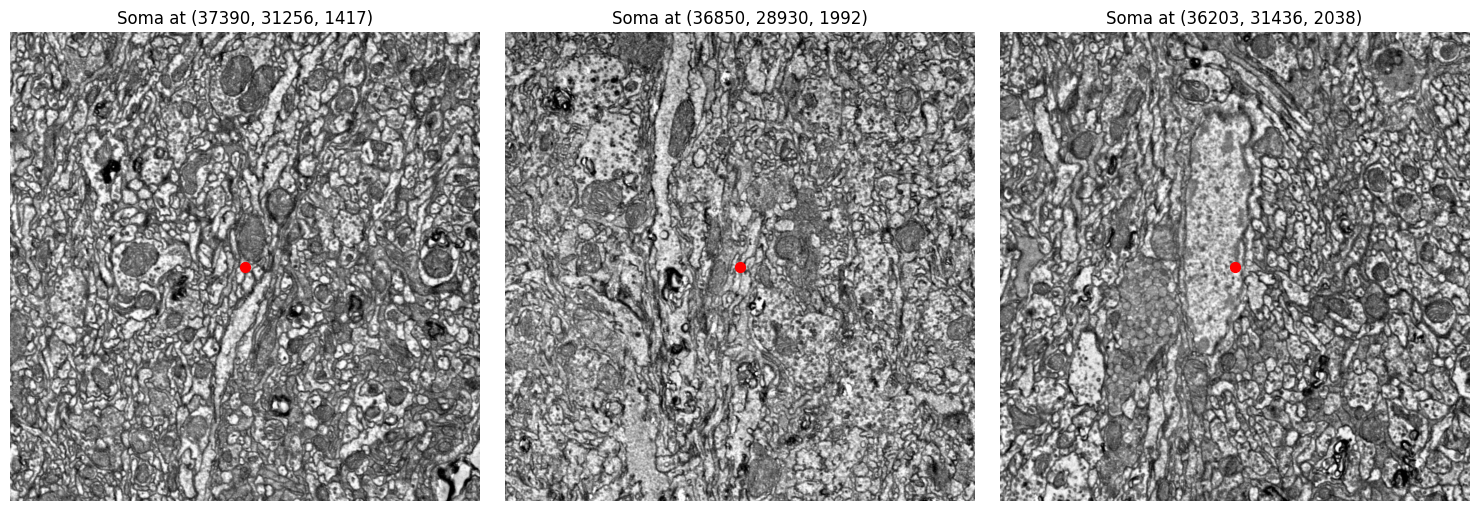

In [7]:
# Plot EM image around the detected somas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, coords in zip(axes, soma_coords_batch):
    x, y, z = map(int, coords)
    img = cp.plot_em_image(x, y, z, size=1000)
    ax.scatter(500, 500, color='red', s=50)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Soma at ({x}, {y}, {z})")
    ax.axis('off')
plt.tight_layout()
plt.show()

We can also plot the soma location on the mesh, but for this we need to convert from pixels coordinates to nanometers. 

In [8]:
from crantpy.utils.config import SCALE_X, SCALE_Y, SCALE_Z
scaling_factors = np.array([SCALE_X, SCALE_Y, SCALE_Z])  # in microns

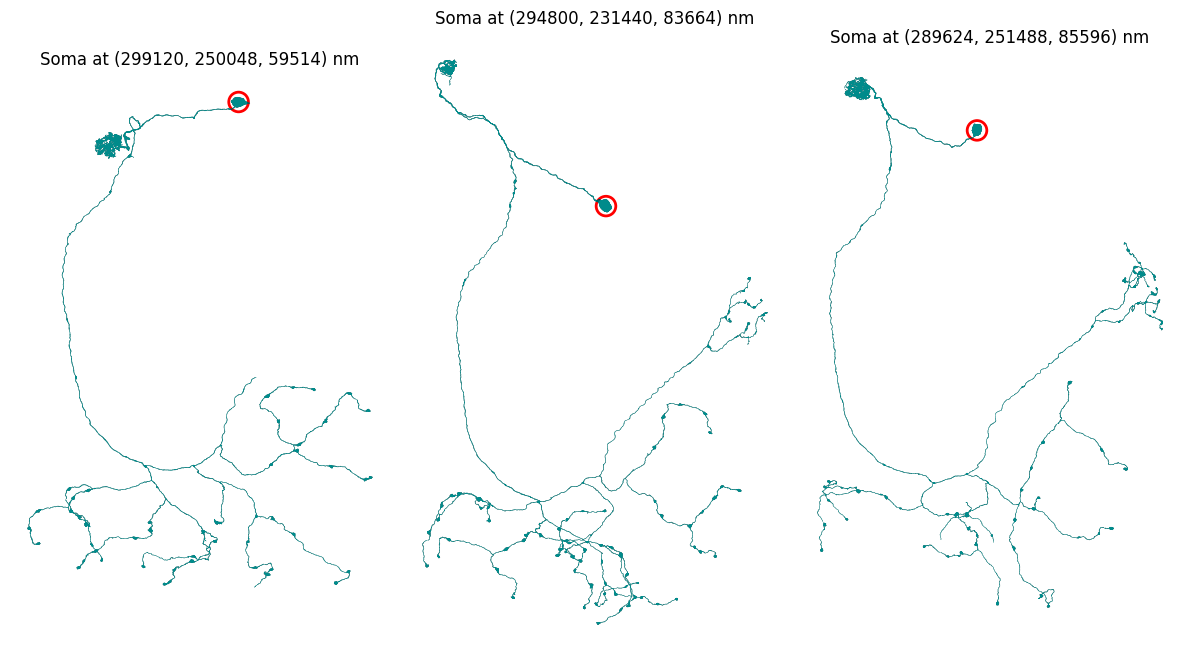

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for i in range(3):
    # scale soma coordinates to nanometers
    soma_nm = [soma_coords_batch[i][0] * SCALE_X, soma_coords_batch[i][1] * SCALE_Y, soma_coords_batch[i][2] * SCALE_Z]
    # get the mesh
    mesh = cp.get_mesh_neuron(sample_ids[i])
    # plot the mesh with soma location
    navis.plot2d(mesh, view=("x", "y"), color='darkcyan', ax=ax[i])
    plt.grid(False)
    ax[i].set_axis_off()
    ax[i].scatter(soma_nm[0], soma_nm[1], color='red', s=200, marker='o', linewidth=2, facecolors='none')
    ax[i].set_title(f"Soma at ({int(soma_nm[0])}, {int(soma_nm[1])}, {int(soma_nm[2])}) nm", fontsize=12)
plt.tight_layout()
plt.show()

## 4. Skeleton Representations

Skeletons are tree-like representations that capture the branching structure of neurons while being much more computationally efficient than meshes.

### Precomputed Skeletons

CRANTpy provides access to precomputed skeletons stored in the database.

In [10]:
# Fetch precomputed skeletons
skeletons = cp.get_skeletons(sample_ids, progress=True, omit_failures=True)
print(f"Fetched {len(skeletons)} skeletons")

# Examine first skeleton
if len(skeletons) > 0:
    skel = skeletons[0]
    print(f"\nSkeleton {skel.id} properties:")
    print(f"  Nodes: {skel.n_nodes:,}")
    print(f"  Cable length: {skel.cable_length:.2f} microns")
    print(f"  Branch points: {skel.n_branch_points}")
    print(f"  End points: {skel.n_endpoints}")

Fetched 3 skeletons

Skeleton 576460752700282748 properties:
  Nodes: 221
  Cable length: 1075895.12 microns
  Branch points: 0
  End points: None


### L2 Graph-Based Skeletons

For higher quality morphology, CRANTpy can generate skeletons from L2 chunks. These are often more accurate than precomputed skeletons.

In [11]:
# Get L2 skeleton for a single neuron
l2_skel = cp.get_l2_skeleton(sample_ids[0], refine=True, progress=True)
print(f"L2 skeleton properties:")
print(f"  Nodes: {l2_skel.n_nodes:,}")
print(f"  Cable length: {l2_skel.cable_length:.2f} microns")
print(f"  Branch points: {l2_skel.n_branch_points}")
print(f"  End points: {l2_skel.n_endpoints}")

L2 skeleton properties:
  Nodes: 309
  Cable length: 1409182.00 microns
  Branch points: 55
  End points: None


In [12]:
# Get L2 skeletons for multiple neurons
l2_skels = cp.get_l2_skeleton(
    sample_ids,
    refine=True,
    progress=True,
    max_threads=3,
    omit_failures=True
)
print(f"\nFetched {len(l2_skels)} L2 skeletons")

# Compare with precomputed skeletons
if len(skeletons) > 0 and len(l2_skels) > 0:
    print(f"\nComparison (first neuron):")
    print(f"  Precomputed: {skeletons[0].cable_length:.2f} μm")
    print(f"  L2-based:    {l2_skels[0].cable_length:.2f} μm")

Fetching L2 skeletons:   0%|          | 0/3 [00:00<?, ?it/s]


Fetched 3 L2 skeletons

Comparison (first neuron):
  Precomputed: 1075895.12 μm
  L2-based:    1409182.00 μm


### L2 Information and Statistics

You can query L2 chunk information directly for fast morphology estimates.

In [13]:
# Get L2 info (fast estimate of morphology)
l2_info = cp.get_l2_info(sample_ids[:5], progress=True)
print("L2 chunk information:")
display(l2_info[['root_id', 'l2_chunks', 'length_um', 'chunks_missing']])

L2 chunk information:


,root_id,l2_chunks,length_um,chunks_missing
0,576460752722405178,377,45.559,0
1,576460752681552812,390,53.886,0
2,576460752700282748,309,39.526,0


In [14]:
# Get detailed L2 chunk info
l2_chunk_info = cp.get_l2_chunk_info(sample_ids[0], progress=True)
print(f"\nDetailed L2 chunk info for neuron {sample_ids[0]}:")
print(f"  Total chunks: {len(l2_chunk_info)}")
print(f"  Columns: {list(l2_chunk_info.columns)}")
display(l2_chunk_info.head())

Fetching L2 chunk info for root 576460752700282748:   0%|          | 0/309 [00:00<?, ?it/s]


Detailed L2 chunk info for neuron 576460752700282748:
  Total chunks: 309
  Columns: ['root_id', 'l2_id', 'x', 'y', 'z', 'vec_x', 'vec_y', 'vec_z', 'size_nm3']


,root_id,l2_id,x,y,z,vec_x,vec_y,vec_z,size_nm3
0,576460752700282748,145804519643567814,55232,19400,2955,0.404541,0.913086,0.054138,138808320
1,576460752700282748,145804519710680256,55172,19400,2956,-0.446289,0.60791,0.656738,483076608
2,576460752700282748,145804588430144816,54276,20836,3189,-0.220215,0.436035,0.872559,1065555456
3,576460752700282748,145804588497240618,55204,22524,3308,0.640625,0.618652,0.455078,568780800
4,576460752700282748,145804657216724259,55192,22528,3308,0.862305,0.304199,0.405029,333666816


### Finding Anchor Locations

Find representative coordinates for neurons (useful for annotations or quick localization).

In [15]:
# Find anchor locations
anchor_locs = cp.find_anchor_loc(sample_ids, progress=True)
print("Anchor locations:")
display(anchor_locs)

Fetching locations:   0%|          | 0/3 [00:00<?, ?it/s]

Anchor locations:


,root_id,x,y,z
0,576460752700282748,74512,62420,1485
1,576460752681552812,73724,58160,2086
2,576460752722405178,72428,62996,2149


### Rerooting Skeletons to the Soma
By default, skeletons may not be rooted at the soma. We can reroot them using the detected soma location.

In [16]:
# need to reroot the skeleton to the soma location
for i in range(3):
    skel = l2_skels[i]
    coords = soma_coords_batch[i] * scaling_factors  # scale to microns
    node_positions = skel.nodes[['x', 'y', 'z']].values
    dists = np.linalg.norm(node_positions - coords, axis=1)
    nearest_node_idx = np.argmin(dists)
    nearest_node_id = skel.nodes.iloc[nearest_node_idx]['node_id']
    print(f"Rerooting skeleton {skel.id} at nearest node {nearest_node_id} to soma location {coords} at distance {dists[nearest_node_idx]:.2f} microns")
    skel.reroot(nearest_node_id, inplace=True)

Rerooting skeleton 576460752700282748 at nearest node 223 to soma location [299120 250048  59514] at distance 1136.51 microns
Rerooting skeleton 576460752681552812 at nearest node 276 to soma location [294800 231440  83664] at distance 346.00 microns
Rerooting skeleton 576460752722405178 at nearest node 239 to soma location [289624 251488  85596] at distance 516.06 microns


## 5. Dotprops - Point Cloud Representations

Dotprops are lightweight point cloud representations with tangent vectors, ideal for NBLAST comparisons.

In [17]:
# Generate dotprops from L2 chunks
dotprops = cp.get_l2_dotprops(
    sample_ids,
    progress=True,
    omit_failures=True
)
print(f"Generated {len(dotprops)} dotprops")

if len(dotprops) > 0:
    dp = dotprops[0]
    print(f"\nDotprop {dp.id} properties:")
    print(f"  Points: {len(dp.points)}")
    print(f"  Has vectors: {dp.vect is not None}")

Fetching L2 IDs:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching L2 vectors:   0%|          | 0/1076 [00:00<?, ?it/s]

Creating dotprops:   0%|          | 0/3 [00:00<?, ?it/s]

Generated 3 dotprops

Dotprop 576460752700282748 properties:
  Points: 241
  Has vectors: True


## 6. Morphometric Analysis

Navis provides extensive morphometric analysis capabilities. Let's explore key metrics.

### Basic Morphometrics

In [18]:
# Use L2 skeletons for morphometric analysis
if len(l2_skels) > 0:
    morphometrics = []
    
    for skel in l2_skels:
        metrics = {
            'root_id': skel.id,
            'cable_length_um': skel.cable_length,
            'n_nodes': skel.n_nodes,
            'n_branch_points': skel.n_branch_points,
            'n_endpoints': skel.n_endpoints,
            'n_branches': len(skel.small_segments),
        }
        morphometrics.append(metrics)
    
    morph_df = pd.DataFrame(morphometrics)
    print("Basic morphometrics:")
    display(morph_df)

Basic morphometrics:


,root_id,cable_length_um,n_nodes,n_branch_points,n_endpoints,n_branches
0,576460752700282748,1409182.000,309,55,None,152
1,576460752681552812,1831399.000,390,68,None,183
2,576460752722405178,1539621.375,377,70,None,203


### Population-Level Morphological Analysis

Let's analyze morphology across a population of neurons.

In [19]:
# Get a larger sample of neurons
opn_sample = opn_ids[:20]

# Get L2 info (fast morphology estimate)
population_l2_info = cp.get_l2_info(opn_sample, progress=True)

print(f"Population morphology statistics:")
print(f"\nCable length (μm):")
print(f"  Mean: {population_l2_info['length_um'].mean():.2f}")
print(f"  Std: {population_l2_info['length_um'].std():.2f}")
print(f"  Range: {population_l2_info['length_um'].min():.2f} - {population_l2_info['length_um'].max():.2f}")

print(f"\nL2 chunks:")
print(f"  Mean: {population_l2_info['l2_chunks'].mean():.0f}")
print(f"  Range: {population_l2_info['l2_chunks'].min():.0f} - {population_l2_info['l2_chunks'].max():.0f}")

Population morphology statistics:

Cable length (μm):
  Mean: 53.39
  Std: 16.61
  Range: 28.83 - 105.19

L2 chunks:
  Mean: 406
  Range: 220 - 795


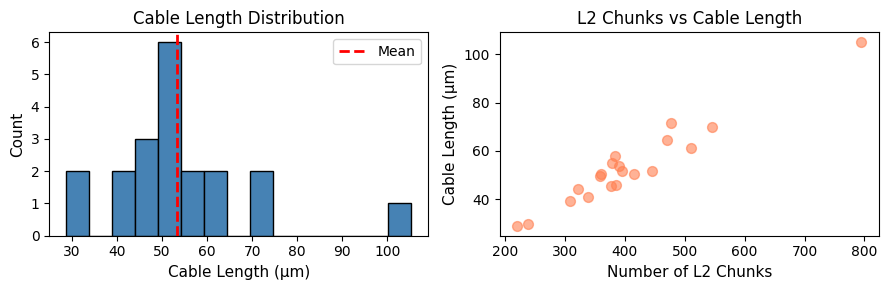

In [20]:
# Visualize population morphology distribution
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Cable length distribution
axes[0].hist(population_l2_info['length_um'], bins=15, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Cable Length (μm)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Cable Length Distribution', fontsize=12)
axes[0].axvline(population_l2_info['length_um'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].legend()

# L2 chunks vs cable length
axes[1].scatter(population_l2_info['l2_chunks'], population_l2_info['length_um'], 
                color='coral', s=50, alpha=0.6)
axes[1].set_xlabel('Number of L2 Chunks', fontsize=11)
axes[1].set_ylabel('Cable Length (μm)', fontsize=11)
axes[1].set_title('L2 Chunks vs Cable Length', fontsize=12)

plt.tight_layout()
plt.show()

### Comparing Cell Types

Cable length statistics by cell class:
            count     mean        std     min       25%      50%      75%  \
cell_class                                                                  
ER           20.0  17.4658   2.524752  13.349  15.96050  16.9815  19.0910   
OPN          20.0  53.3934  16.605328  28.827  45.23075  51.0715  58.7805   

                max  
cell_class           
ER           23.053  
OPN         105.185  


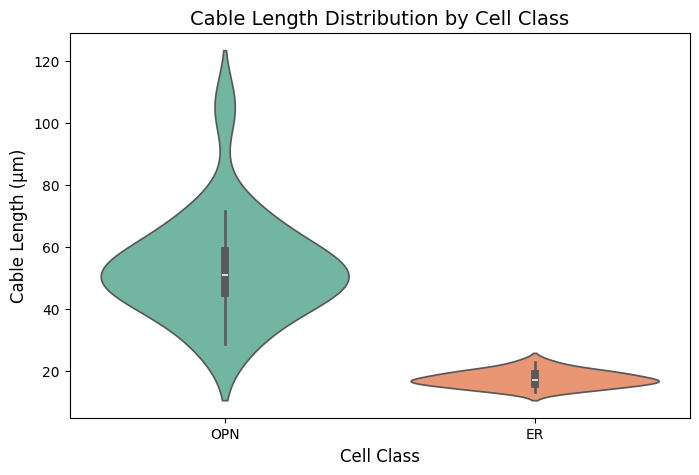

In [21]:
# Compare morphology across different cell classes
er_neurons = cp.NeuronCriteria(cell_class='ER')
er_ids = er_neurons.get_roots()[:20]

# Get L2 info for both populations
opn_morph = cp.get_l2_info(opn_sample, progress=True)
opn_morph['cell_class'] = 'OPN'

er_morph = cp.get_l2_info(er_ids, progress=True)
er_morph['cell_class'] = 'ER'

# Combine
combined_morph = pd.concat([opn_morph, er_morph], ignore_index=True)

print("Cable length statistics by cell class:")
print(combined_morph.groupby('cell_class')['length_um'].describe())

# plot the distribution of cable lengths by cell class
plt.figure(figsize=(8, 5))
sns.violinplot(x='cell_class', y='length_um', data=combined_morph, palette='Set2')
plt.title('Cable Length Distribution by Cell Class', fontsize=14)
plt.xlabel('Cell Class', fontsize=12)
plt.ylabel('Cable Length (μm)', fontsize=12)
plt.grid(False)
plt.show()

## 7. Advanced Navis Integration

CRANTpy neurons are fully compatible with navis, enabling access to its extensive analysis toolkit.

### Resampling

In [22]:
# Resample skeleton to uniform spacing
if len(l2_skels) > 0:
    original = l2_skels[0]
    resampled = navis.resample_skeleton(original, resample_to=1000)  # 1 micron spacing
    
    print(f"Resampling:")
    print(f"  Original nodes: {original.n_nodes}")
    print(f"  Resampled nodes: {resampled.n_nodes}")
    print(f"  Original cable length: {original.cable_length:.2f} μm")
    print(f"  Resampled cable length: {resampled.cable_length:.2f} μm")


Resampling:
  Original nodes: 309
  Resampled nodes: 1317
  Original cable length: 1409182.00 μm
  Resampled cable length: 1402008.00 μm


### Smoothing

Smoothing:   0%|          | 0/97 [00:00<?, ?it/s]

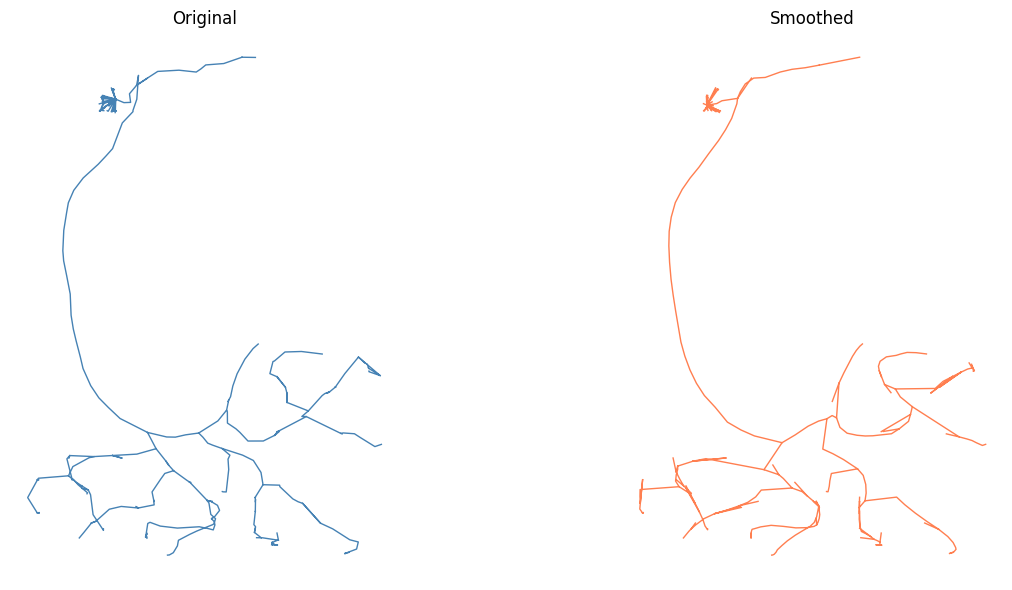

In [23]:
# Smooth skeleton
smoothed = navis.smooth_skeleton(l2_skels[0], window=5)

# Visualize original vs smoothed
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

navis.plot2d(l2_skels[0], view=('x','y'), method='2d', ax=axes[0], color='steelblue')
axes[0].set_title('Original', fontsize=12)
axes[0].grid(False)
axes[0].set_axis_off()

navis.plot2d(smoothed, view=('x','y'), method='2d', ax=axes[1], color='coral')
axes[1].set_title('Smoothed', fontsize=12)
axes[1].grid(False)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

### Trim branches

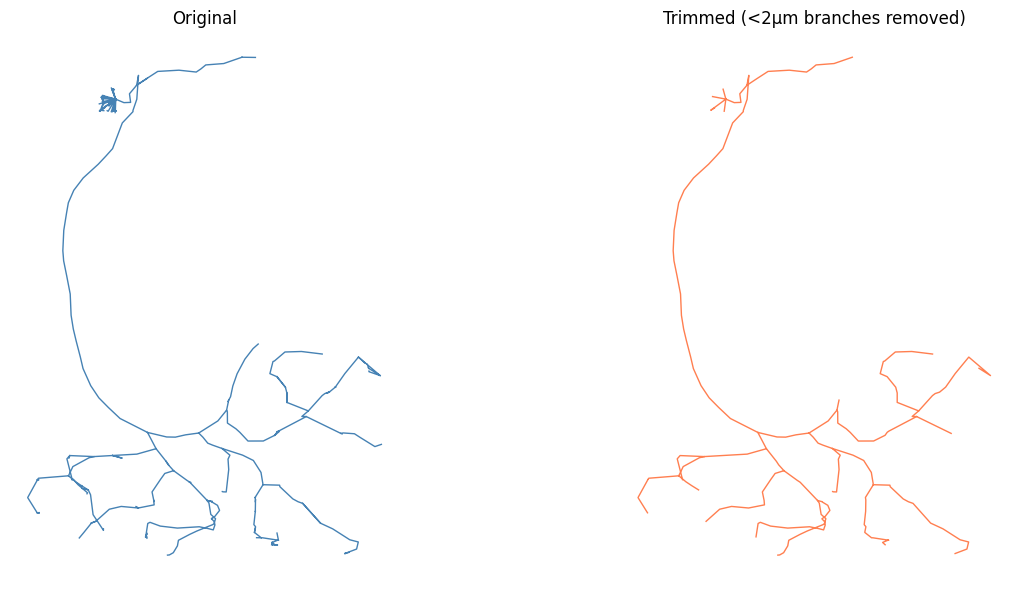

In [24]:
# trim branches shorter than a threshold
trimmed = navis.prune_twigs(l2_skels[0], size=5000*SCALE_X)
# Visualize original vs trimmed
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
navis.plot2d(l2_skels[0], view=('x','y'), method='2d', ax=axes[0], color='steelblue')
axes[0].set_title('Original', fontsize=12)
axes[0].grid(False)
axes[0].set_axis_off()

navis.plot2d(trimmed, view=('x','y'), method='2d', ax=axes[1], color='coral')
axes[1].set_title('Trimmed (<2μm branches removed)', fontsize=12)
axes[1].grid(False)
axes[1].set_axis_off()
plt.tight_layout()
plt.show()

### Neuron Similarity (NBLAST)

NBLAST is a powerful algorithm for quantifying morphological similarity between neurons. It operates on dotprops representations.

Fetching L2 IDs:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching L2 vectors:   0%|          | 0/12093 [00:00<?, ?it/s]

Creating dotprops:   0%|          | 0/30 [00:00<?, ?it/s]

Dividing:   0%|          | 0/30 [00:00<?, ?it/s]

Preparing:   0%|          | 0/1 [00:00<?, ?it/s]

NBlasting:   0%|          | 0/30 [00:00<?, ?it/s]

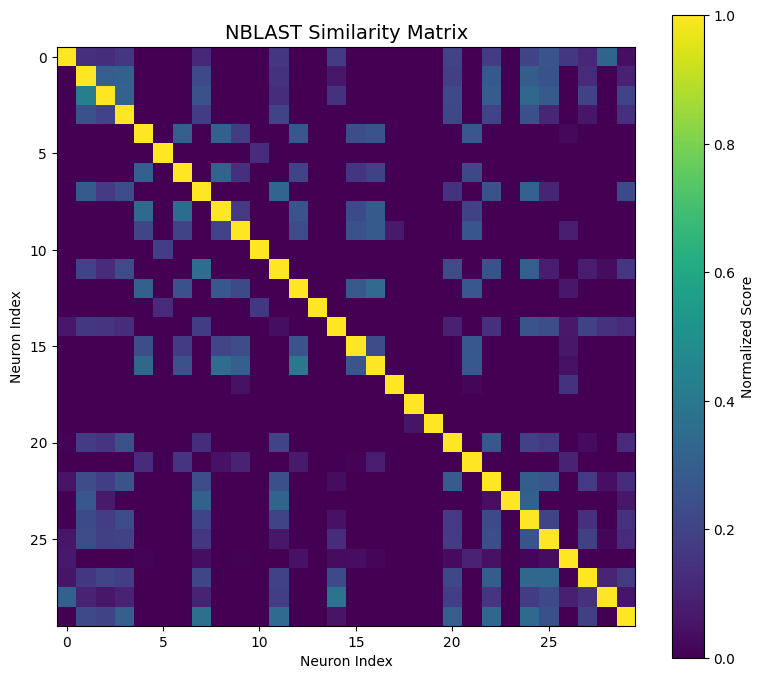


Most similar pair: neurons 2 and 1
Similarity score: 0.427


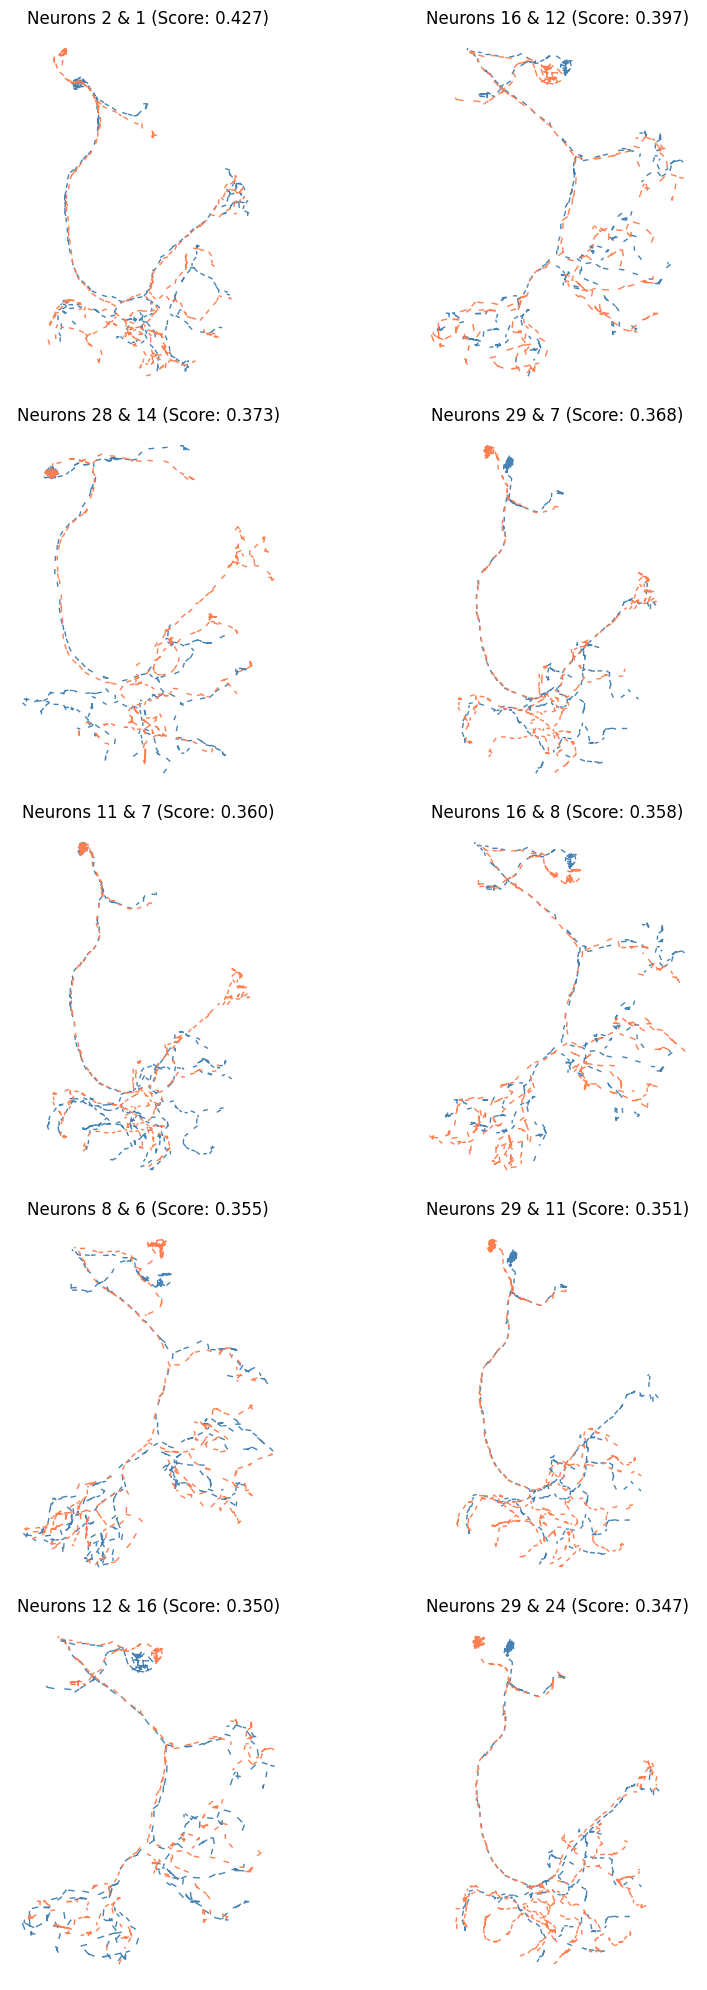

In [25]:
# get the dotprops for 30 neurons
dotprops = cp.get_l2_dotprops(
    opn_ids[:30],
    progress=True,
    omit_failures=True
)/1000 # scale to microns


# NBLAST requires dotprops
# Compute pairwise similarity
scores = navis.nblast(dotprops, dotprops).values

# Visualize similarity matrix
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(scores, cmap='viridis', vmin=0, vmax=1)
ax.set_title('NBLAST Similarity Matrix', fontsize=14)
ax.set_xlabel('Neuron Index')
ax.set_ylabel('Neuron Index')
plt.colorbar(im, ax=ax, label='Normalized Score')
plt.tight_layout()
plt.show()

# Find most similar pair
np.fill_diagonal(scores, 0)  # Exclude self-comparisons
max_idx = np.unravel_index(scores.argmax(), scores.shape)
print(f"\nMost similar pair: neurons {max_idx[0]} and {max_idx[1]}")
print(f"Similarity score: {scores[max_idx]:.3f}")

# plot the closest 10 pairs
closest_pairs = np.dstack(np.unravel_index(np.argsort(-scores.ravel()), scores.shape))[0][:10]
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for ax, (i, j) in zip(axes.ravel(), closest_pairs):
    navis.plot2d(dotprops[i], view=('x', 'y'), method='2d', ax=ax, color='steelblue')
    navis.plot2d(dotprops[j], view=('x', 'y'), method='2d', ax=ax, color='coral')
    ax.set_title(f'Neurons {i} & {j} (Score: {scores[i, j]:.3f})', fontsize=12)
    ax.grid(False)
    ax.set_axis_off()
plt.tight_layout()
plt.show()


## 8. Distance Calculations

Understanding distances within neurons is crucial for many analyses. We'll explore both Euclidean (straight-line) and geodesic (along-the-arbor) distances.

#### Sampling Rate (Node-to-Parent Distances)

First, let's calculate the average distance between nodes and their parents - this tells us about the skeleton's sampling rate:


Sampling rate statistics:
  Mean distance between nodes: 4575.27 nm
  Std: 3191.86 nm
  Median: 4793.04 nm


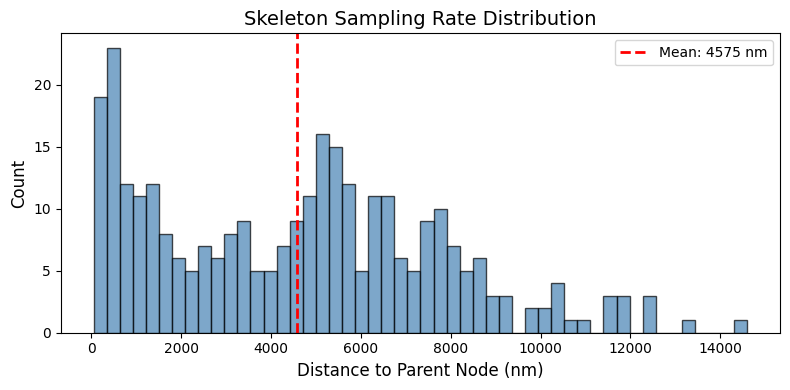

In [26]:
skel = l2_skels[0]

# Get nodes but remove the root (has no parent)
nodes = skel.nodes[skel.nodes.parent_id >= 0]

# Get the x/y/z coordinates of all nodes (except root)
node_locs = nodes[['x', 'y', 'z']].values

# For each node, get its parent's location
parent_locs = skel.nodes.set_index('node_id').loc[nodes.parent_id.values, ['x', 'y', 'z']].values

# Calculate Euclidean distances
distances = np.sqrt(np.sum((node_locs - parent_locs) ** 2, axis=1))

print(f"Sampling rate statistics:")
print(f"  Mean distance between nodes: {np.mean(distances):.2f} nm")
print(f"  Std: {np.std(distances):.2f} nm")
print(f"  Median: {np.median(distances):.2f} nm")

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(distances, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Distance to Parent Node (nm)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Skeleton Sampling Rate Distribution', fontsize=14)
plt.axvline(np.mean(distances), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(distances):.0f} nm')
plt.legend()
plt.tight_layout()
plt.show()

#### Geodesic Distance: Single Node-to-Node Query

For distances along the neuron's branching structure, we need geodesic distances. Let's calculate the distance from the soma (root) to a terminal node:

In [27]:

# Pick a terminal node
end_nodes = skel.nodes[skel.nodes.type == 'end'].node_id.values
terminal_node = end_nodes[0]

# Calculate geodesic distance from root to terminal node
d_geo = navis.dist_between(skel, skel.root[0], terminal_node)

# Also calculate Euclidean distance for comparison
end_loc = skel.nodes.set_index('node_id').loc[terminal_node, ['x', 'y', 'z']].values
root_loc = skel.nodes.set_index('node_id').loc[skel.root[0], ['x', 'y', 'z']].values
d_eucl = np.sqrt(np.sum((end_loc - root_loc) ** 2))

print(f"Distance from root to terminal node {terminal_node}:")
print(f"  Geodesic (along arbor): {d_geo:.2f} nm ({d_geo/1000:.2f} μm)")
print(f"  Euclidean (straight line): {d_eucl:.2f} nm ({d_eucl/1000:.2f} μm)")
print(f"  Ratio (tortuosity): {d_geo/d_eucl:.2f}x")

Distance from root to terminal node 5:
  Geodesic (along arbor): 307062.21 nm (307.06 μm)
  Euclidean (straight line): 197367.96 nm (197.37 μm)
  Ratio (tortuosity): 1.56x


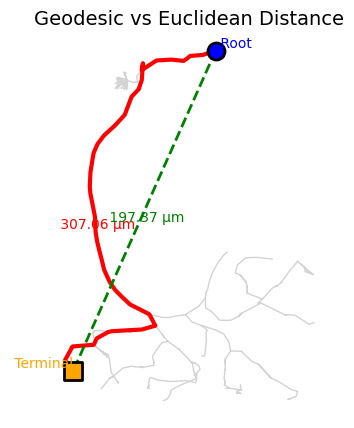

In [28]:
# Visualize the difference between geodesic and Euclidean distances

# Find the shortest path along the skeleton
path = nx.shortest_path(skel.graph.to_undirected(), skel.root[0], terminal_node)

# Get coordinates for the path
path_co = skel.nodes.set_index('node_id').loc[path, ['x', 'y', 'z']].copy()

# Plot the neuron
fig, ax = navis.plot2d(skel, color='lightgray', method='2d', view=('x', 'y'), figsize=(5, 5))

# Add geodesic path (along the skeleton)
ax.plot(path_co.x, path_co.y, color='red', linewidth=3, label='Geodesic path', zorder=10)

# Add Euclidean path (straight line)
ax.plot([root_loc[0], end_loc[0]], [root_loc[1], end_loc[1]], 
        color='green', linewidth=2, linestyle='--', label='Euclidean path', zorder=10)

# Mark root and terminal node
ax.scatter(root_loc[0], root_loc[1], s=150, color='blue', marker='o', 
           label='Root (soma)', zorder=15, edgecolors='black', linewidths=2)
ax.scatter(end_loc[0], end_loc[1], s=150, color='orange', marker='s', 
           label='Terminal node', zorder=15, edgecolors='black', linewidths=2)

# Add text annotations
ax.text(root_loc[0], root_loc[1], ' Root', color='blue', fontsize=10, verticalalignment='bottom', horizontalalignment='left', zorder=20)
ax.text(end_loc[0], end_loc[1], ' Terminal', color='orange', fontsize=10, verticalalignment='bottom', horizontalalignment='right', zorder=20)   

# add distance annotations
mid_geo = path_co.iloc[len(path_co)//2]
mid_eucl = [(root_loc[0] + end_loc[0]) / 2, (root_loc[1] + end_loc[1]) / 2]
ax.text(mid_geo.x, mid_geo.y, f' {d_geo/1000:.2f} μm', color='red', fontsize=10, verticalalignment='bottom', horizontalalignment='center', zorder=20)
ax.text(mid_eucl[0], mid_eucl[1], f' {d_eucl/1000:.2f} μm', color='green', fontsize=10, verticalalignment='top', horizontalalignment='center', zorder=20)        

ax.set_title('Geodesic vs Euclidean Distance', fontsize=14)
ax.set_axis_off()
plt.show()

#### Geodesic Distance Matrix

For analyzing distances across many nodes, we can use `navis.geodesic_matrix()` to compute a distance matrix. Let's calculate distances between all terminal nodes:

In [29]:
# Calculate distances from all end nodes to all other nodes
ends = skel.nodes[skel.nodes.type == 'end'].node_id.values
print(f"Calculating geodesic distances for {len(ends)} terminal nodes...")

# Get the distance matrix
dist_matrix = navis.geodesic_matrix(skel, from_=ends)

# Subset to only end-to-end distances
dist_matrix_ends = dist_matrix.loc[ends, ends]

print(f"\nDistance matrix shape: {dist_matrix_ends.shape}")
print(f"Distance statistics (μm):")
print(f"  Mean: {dist_matrix_ends.values.mean()/1000:.2f}")
print(f"  Median: {np.median(dist_matrix_ends.values)/1000:.2f}")
print(f"  Max: {dist_matrix_ends.values.max()/1000:.2f}")

display(dist_matrix_ends.head())

Calculating geodesic distances for 97 terminal nodes...

Distance matrix shape: (97, 97)
Distance statistics (μm):
  Mean: 194.81
  Median: 219.03
  Max: 379.44


,5,6,7,8,44,12,19,10,39,42,...,286,282,281,289,290,304,301,307,305,306
5,0.000000,1470.138794,21770.945312,21924.505859,43284.164062,82830.328125,68335.960938,162903.531250,155059.750000,97709.773438,...,196621.8750,194101.625000,194177.703125,213741.078125,215143.28125,214334.812500,206430.062500,228993.875000,230859.656250,229488.406250
6,1470.138794,0.000000,21653.496094,21807.058594,43166.718750,82712.882812,68218.515625,162786.093750,154942.312500,97592.328125,...,196504.4375,193984.187500,194060.265625,213623.640625,215025.84375,214217.375000,206312.625000,228876.437500,230742.218750,229370.968750
7,21770.945312,21653.496094,0.000000,963.262634,22322.921875,61869.085938,47374.718750,141942.296875,134098.500000,76748.531250,...,175660.6250,173140.375000,173216.468750,192779.843750,194182.03125,193373.578125,185468.812500,208032.625000,209898.406250,208527.156250
8,21924.505859,21807.058594,963.262634,0.000000,22476.482422,62022.648438,47528.281250,142095.859375,134252.062500,76902.093750,...,175814.1875,173293.937500,173370.031250,192933.406250,194335.59375,193527.140625,185622.375000,208186.187500,210051.968750,208680.718750
44,43284.164062,43166.718750,22322.921875,22476.482422,0.000000,58810.382812,44316.015625,138883.593750,131039.796875,73689.828125,...,172601.9375,170081.671875,170157.750000,189721.125000,191123.34375,190314.875000,182410.109375,204973.921875,206839.703125,205468.453125


<Figure size 1000x800 with 0 Axes>

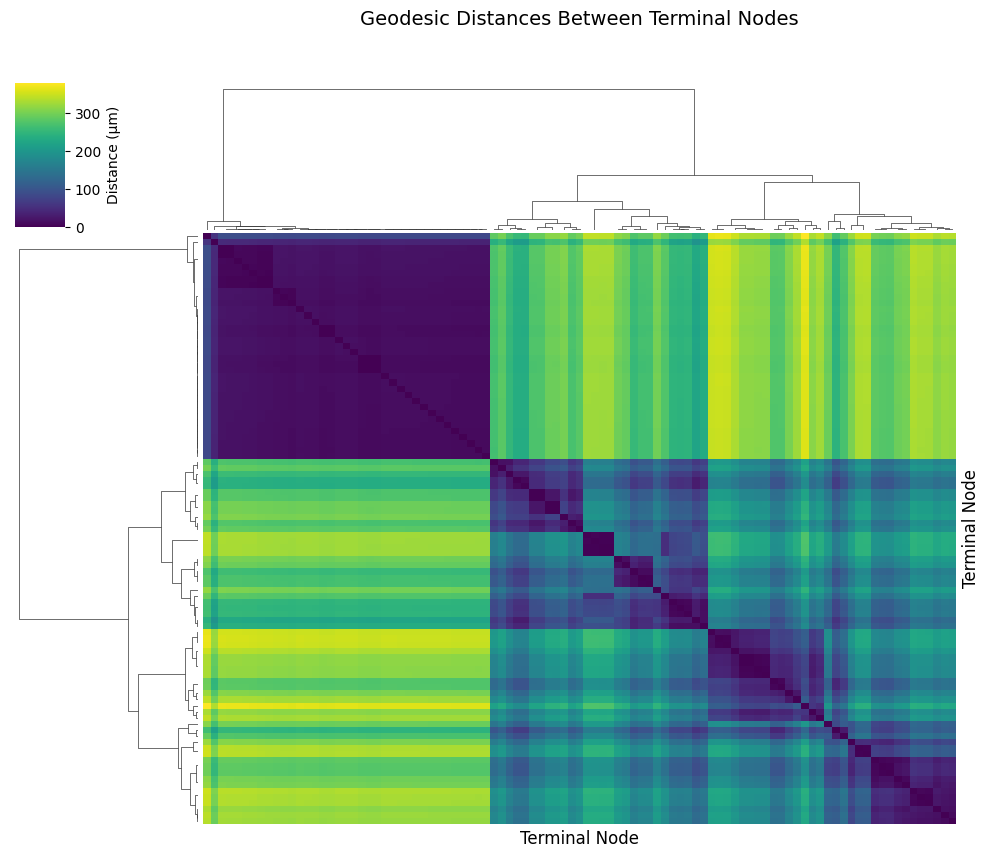


Note: Clustering in the heatmap can reveal dendritic vs axonal compartments!
Nodes that cluster together are likely in the same compartment.


In [30]:
# Visualize the distance matrix with hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

# Generate linkage from the distances
Z = linkage(squareform(dist_matrix_ends.values/1000, checks=False), method='ward')

# Create clustermap
fig = plt.figure(figsize=(10, 8))
cm = sns.clustermap(
    dist_matrix_ends.values/1000,  # Convert to microns
    cmap='viridis',
    col_linkage=Z,
    row_linkage=Z,
    cbar_kws={'label': 'Distance (μm)'},
    figsize=(10, 8)
)

cm.ax_heatmap.set_xlabel('Terminal Node', fontsize=12)
cm.ax_heatmap.set_ylabel('Terminal Node', fontsize=12)
cm.ax_heatmap.set_title('Geodesic Distances Between Terminal Nodes', fontsize=14, pad=150)

# Remove tick labels for cleaner look
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])

plt.show()

print("\nNote: Clustering in the heatmap can reveal dendritic vs axonal compartments!")
print("Nodes that cluster together are likely in the same compartment.")

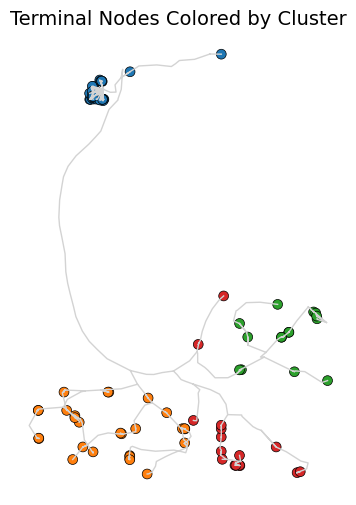

In [31]:
# get the clusters and plot them on the neuron
from scipy.cluster.hierarchy import fcluster
# Cut the dendrogram to form 2 clusters
clusters = fcluster(Z, t=4, criterion='maxclust')

# plot all the nodes colored by cluster
fig, ax = navis.plot2d(skel, method='2d', view=('x', 'y'), color='lightgray', figsize=(6, 6))
node_colors = sns.color_palette('tab10', n_colors=max(clusters)).as_hex()
node_colors = [node_colors[c-1] for c in clusters]
ax.scatter(
    skel.nodes.set_index('node_id').loc[ends, 'x'],
    skel.nodes.set_index('node_id').loc[ends, 'y'],
    c=node_colors, s=50, edgecolors='black', linewidths=0.5, label='Terminal Nodes'
)
ax.set_title('Terminal Nodes Colored by Cluster', fontsize=14)
ax.set_axis_off()
plt.show()

#### Distance-based Node Coloring

We can also use distances to color the neuron, highlighting how far each node is from the root:

Distance from root statistics:
  Mean: 174.70 μm
  Max: 311.93 μm
  Std: 76.62 μm


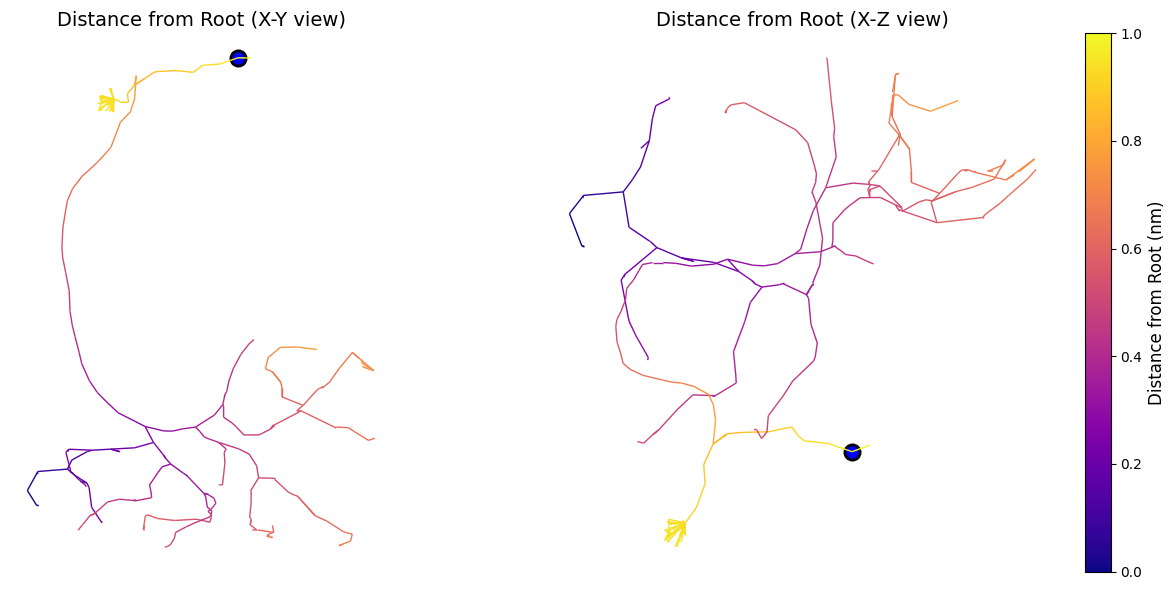

In [32]:
# Calculate distance from root to all nodes
root_node = skel.root[0]
all_node_ids = skel.nodes.node_id.values
distances_all = navis.geodesic_matrix(skel, from_=all_node_ids)

# Add to nodes dataframe
skel.nodes['root_dist'] = distances_all.loc[np.argmin(all_node_ids-root_node), :].values

# set nan to 0 
skel.nodes['root_dist'] = skel.nodes['root_dist'].fillna(0)

print(f"Distance from root statistics:")
print(f"  Mean: {skel.nodes['root_dist'].mean()/1000:.2f} μm")
print(f"  Max: {skel.nodes['root_dist'].max()/1000:.2f} μm")
print(f"  Std: {skel.nodes['root_dist'].std()/1000:.2f} μm")

# Plot neuron colored by distance from root
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# View 1: X-Y
navis.plot2d(
    skel,
    color_by='root_dist',
    palette='plasma',
    method='2d',
    view=('x', 'y'),
    ax=axes[0]
)
# plot the root
axes[0].scatter(
    root_loc[0], root_loc[1],
    color='blue', s=120, edgecolors='black', linewidths=2, label='Root'
)
axes[0].set_title('Distance from Root (X-Y view)', fontsize=14)
axes[0].set_axis_off()

# View 2: X-Z
navis.plot2d(
    skel,
    color_by='root_dist',
    palette='plasma',
    method='2d',
    view=('x', 'z'),
    ax=axes[1]
)
# plot the root
axes[1].scatter(
    root_loc[0], root_loc[2],
    color='blue', s=120, edgecolors='black', linewidths=2, label='Root'
)
axes[1].set_title('Distance from Root (X-Z view)', fontsize=14)
axes[1].set_axis_off()

# add colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), orientation='vertical', fraction=0.05, pad=0.1, cax=axes[1].inset_axes([1.05, 0, 0.05, 1]))
cbar.set_label('Distance from Root (nm)', fontsize=12)

plt.tight_layout()
plt.show()

## 9. Advanced Morphometric Analysis

### Segment Analysis

Navis provides `segment_analysis()` which collects comprehensive morphometrics for each linear segment (between branch points), including Strahler index, cable length, distance to root, and tortuosity.

In [33]:
# need to reroot the skeleton to the soma location
for i in range(3):
    skel = l2_skels[i]
    coords = soma_coords_batch[i] * scaling_factors  # scale to microns
    node_positions = skel.nodes[['x', 'y', 'z']].values
    dists = np.linalg.norm(node_positions - coords, axis=1)
    nearest_node_idx = np.argmin(dists)
    nearest_node_id = skel.nodes.iloc[nearest_node_idx]['node_id']
    print(f"Rerooting skeleton {skel.id} at nearest node {nearest_node_id} to soma location {coords} at distance {dists[nearest_node_idx]:.2f} microns")
    skel.reroot(nearest_node_id, inplace=True)

Rerooting skeleton 576460752700282748 at nearest node 223 to soma location [299120 250048  59514] at distance 1136.51 microns
Rerooting skeleton 576460752681552812 at nearest node 276 to soma location [294800 231440  83664] at distance 346.00 microns
Rerooting skeleton 576460752722405178 at nearest node 239 to soma location [289624 251488  85596] at distance 516.06 microns


In [34]:
# Perform comprehensive segment analysis
seg_analysis = navis.segment_analysis(l2_skels[0])

print(f"Segment analysis results:")
print(f"  Total segments: {len(seg_analysis)}")
print(f"\nFirst few segments:")
display(seg_analysis.head())

print(f"\nSummary statistics:")
display(seg_analysis[['length', 'tortuosity', 'root_dist', 'strahler_index']].describe())

Segment analysis results:
  Total segments: 152

First few segments:


,length,tortuosity,root_dist,strahler_index,radius_mean,radius_min,radius_max,volume
0,793.792721,1.009957,306268.419732,1,221.333333,193,244,1.326052e+08
1,20572.301259,1.093203,285696.118473,2,271.000000,193,314,5.024232e+09
2,676.346065,1.000000,306268.419732,1,191.000000,189,193,7.751780e+07
3,12285.961101,1.034210,273410.157373,2,212.750000,117,314,9.929913e+08
4,404.850590,1.000000,285696.118473,1,243.000000,172,314,7.724016e+07



Summary statistics:


,length,tortuosity,root_dist,strahler_index
count,152.000000,152.000000,152.000000,152.000000
mean,9270.934315,1.037665,225768.867012,1.513158
std,16940.222298,0.100488,106298.128510,0.813681
min,55.172457,1.000000,0.000000,1.000000
25%,1192.933156,1.000000,80607.110184,1.000000
50%,4983.385660,1.000000,265986.027429,1.000000
75%,10191.787491,1.024821,306346.790386,2.000000
max,173550.345434,1.788708,360682.099962,5.000000


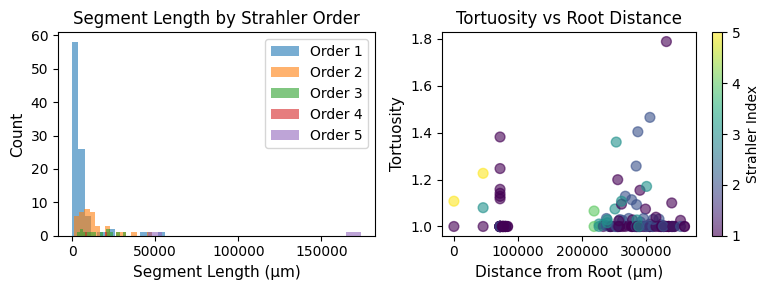

In [35]:
# Visualize segment properties
seg_analysis = navis.segment_analysis(l2_skels[0])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Segment length distribution by Strahler order
for order in sorted(seg_analysis['strahler_index'].unique()):
    data = seg_analysis[seg_analysis['strahler_index'] == order]['length']
    axes[0].hist(data, bins=15, alpha=0.6, label=f'Order {int(order)}')
axes[0].set_xlabel('Segment Length (μm)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Segment Length by Strahler Order', fontsize=12)
axes[0].legend()

# Tortuosity vs distance from root
scatter = axes[1].scatter(
    seg_analysis['root_dist'], 
    seg_analysis['tortuosity'],
    c=seg_analysis['strahler_index'],
    cmap='viridis',
    s=50,
    alpha=0.6
)
axes[1].set_xlabel('Distance from Root (μm)', fontsize=11)
axes[1].set_ylabel('Tortuosity', fontsize=11)
axes[1].set_title('Tortuosity vs Root Distance', fontsize=12)
plt.colorbar(scatter, ax=axes[1], label='Strahler Index')

plt.tight_layout()
plt.show()

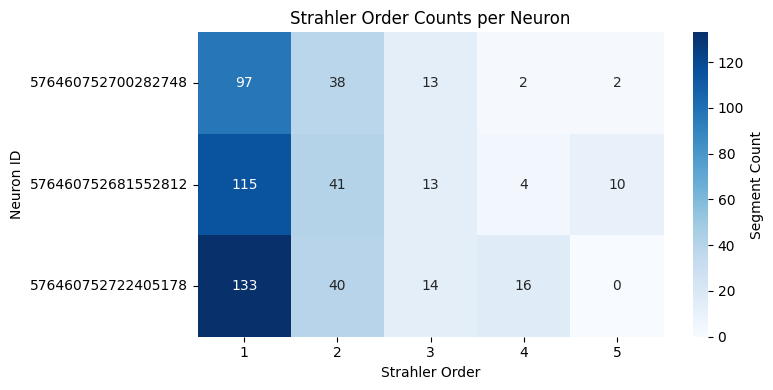

In [36]:
# compare strahler order counts between neurons

# calculate strahler order counts for each neuron
strahler_counts = []
for skel in l2_skels:
    seg_analysis = navis.segment_analysis(skel)
    counts = seg_analysis['strahler_index'].value_counts().to_dict()
    counts['root_id'] = skel.id
    strahler_counts.append(counts)
strahler_df = pd.DataFrame(strahler_counts).fillna(0).set_index('root_id').astype(int)

# show as a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(strahler_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Segment Count'})
plt.title('Strahler Order Counts per Neuron')
plt.xlabel('Strahler Order')
plt.ylabel('Neuron ID')
plt.tight_layout()
plt.show()

### Visualizing Node Properties

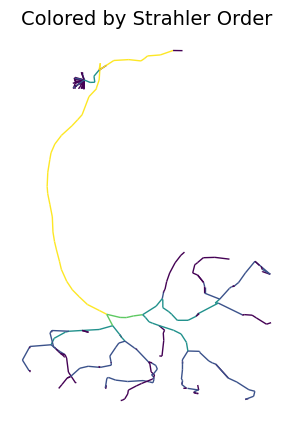

In [37]:
# add strahler index to skeleton nodes
navis.strahler_index(l2_skels[0])

# Color by Strahler order
fig, ax = navis.plot2d(
    l2_skels[0],
    view=('x', 'y'),
    color_by='strahler_index',
    palette='viridis',
    method='2d',
    figsize=(5, 5)
)
ax.grid(False)
ax.set_title('Colored by Strahler Order', fontsize=14)
ax.set_axis_off()
plt.show()


### Sholl analysis

Sholl analysis quantifies branching complexity as a function of distance from the soma.

#### Euclidean distance from soma
Typically, Sholl analysis is performed using Euclidean distance from the soma.

,intersections,cable_length,branch_points
radius,,,
4283.629551,0,0.000000,0
8567.259101,0,13065.068359,0
12850.888652,0,0.000000,0
17134.518202,0,9701.698242,0
21418.147753,0,3230.100830,0


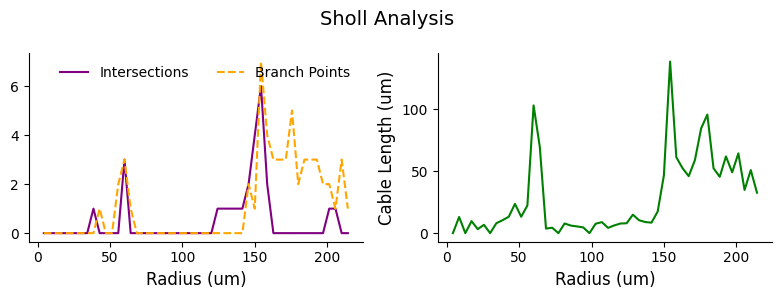

In [38]:
# perform sholl analysis with euclidean radii of 50 nm increments from the root
sholl_results = navis.sholl_analysis(l2_skels[0], radii=50, center='root')
display(sholl_results.head())

# plot sholl results
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].plot(sholl_results.index/1000, sholl_results['intersections'].values, ls ='-', color='purple', label='Intersections')
ax[0].plot(sholl_results.index/1000, sholl_results['branch_points'].values, ls='--', color='orange', label='Branch Points')
ax[0].set_xlabel('Radius (um)', fontsize=12)
ax[0].spines[['top', 'right']].set_visible(False)
ax[0].legend(frameon=False, ncols = 2)

ax[1].plot(sholl_results.index/1000, sholl_results['cable_length'].values/1000, ls='-', color='green')
ax[1].set_xlabel('Radius (um)', fontsize=12)
ax[1].set_ylabel('Cable Length (um)', fontsize=12)
ax[1].spines[['top', 'right']].set_visible(False)

plt.suptitle('Sholl Analysis', fontsize=14)
plt.tight_layout()


#### Geodesic distance from soma
Sholl analysis can also be performed using geodesic distance along the neuron structure.

,intersections,cable_length,branch_points
radius,,,
7480.571289,0,5413.287598,0
14961.142578,0,14514.019531,0
22441.714844,0,6069.560547,0
29922.285156,0,6710.543457,0
37402.855469,0,8032.163574,0


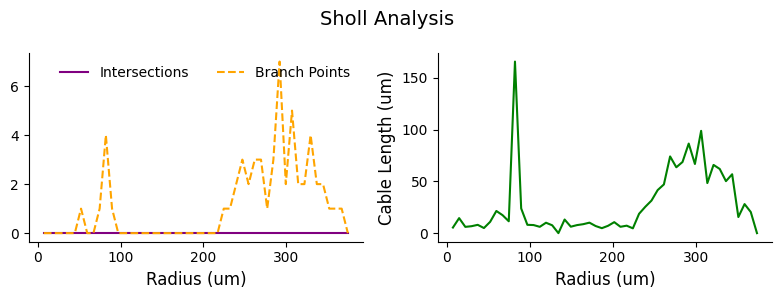

In [39]:
# perform sholl analysis with euclidean radii of 50 nm increments from the root
sholl_results = navis.sholl_analysis(l2_skels[0], radii=50, center='root', geodesic=True)
display(sholl_results.head())

# plot sholl results
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].plot(sholl_results.index/1000, sholl_results['intersections'].values, ls ='-', color='purple', label='Intersections')
ax[0].plot(sholl_results.index/1000, sholl_results['branch_points'].values, ls='--', color='orange', label='Branch Points')
ax[0].set_xlabel('Radius (um)', fontsize=12)
ax[0].spines[['top', 'right']].set_visible(False)
ax[0].legend(frameon=False, ncols = 2)

ax[1].plot(sholl_results.index/1000, sholl_results['cable_length'].values/1000, ls='-', color='green')
ax[1].set_xlabel('Radius (um)', fontsize=12)
ax[1].set_ylabel('Cable Length (um)', fontsize=12)
ax[1].spines[['top', 'right']].set_visible(False)

plt.suptitle('Sholl Analysis', fontsize=14)
plt.tight_layout()


## Summary

In this comprehensive deep dive, you learned:

✅ **Mesh representations** - Fetching and analyzing neuron surface meshes  
✅ **Skeleton representations** - Multiple methods (precomputed, L2-based)  
✅ **L2 graph analysis** - High-quality morphology from L2 chunks  
✅ **Dotprops** - Lightweight representations for fast comparisons  
✅ **Morphometric analysis** - Cable length, branching, Strahler order, tortuosity  
✅ **Soma detection** - Automated identification from mesh and skeleton data  
✅ **Visualization** - 2D, 3D, and property-based coloring  
✅ **Population analysis** - Comparing morphology across neuron groups  
✅ **Navis integration** - Advanced analysis (NBLAST, resampling, smoothing)  

### Key Takeaways

1. **Choose the right representation**: Meshes for detail, skeletons for analysis, dotprops for comparison
2. **L2-based morphology**: Often more accurate than precomputed data
3. **Fast estimates**: Use `get_l2_info()` for quick morphology overview
4. **Leverage navis**: Full access to navis's morphometric toolkit
5. **Population studies**: Compare morphology across cell types and conditions